In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
import time
from kornia.enhance.histogram import histogram2d
from bmadx.track import *
tkwargs = {
    "dtype" : torch.double
}
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__
%config InlineBackend.figure_format = 'retina'

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

In [3]:
def torchquadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                    X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                     Y_OFFSET=Y_OFFSET, TILT=TILT)

# Offset estimation  


In this example, we want to find the offsets of the quadrupoles in a beamline given the 2D beam profile downstream.  
Lets start by optimizing three quadrupoles with random offsets: 

In [4]:
# Initial beam distribution

s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)

sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
cov[0,1] = 0.5e-6
cov[1,0] = cov[0,1]
cov[0,2] = -0.5e-6
cov[2,0] = cov[0,2]
torch.manual_seed(0)
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, 16*cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

In [5]:
def train_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%100==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        
    return np.asarray(history_param), np.asarray(history_loss)

## Ground truth offset

In [6]:
# random ground truth offsets:
torch.manual_seed(0)
offsets_x_true = torch.normal(mean=0, std=1e-2, size=(3,), **tkwargs)
offsets_x_true

tensor([1.5409961082440433e-02, -2.9342890576094637e-03, -2.1787893820745575e-02],
       dtype=torch.float64)

In [7]:
def beamsize_offsets(k1s, offsets_x):
    """Returns sqrt(std(x)**2 + std(y)**2) after lattice composed by len(k1s)+1 
    drifts with len(k1s) quadrupoles in between. The ith quadrupole has strength
    k1s[i] and x offset x[i].
    """
    # Lattice fixed parameters
    L_d = 1.00 # Drift length
    L_q = 0.1 # Quad length 
    drift = Drift(L=L_d)
    lattice = [drift]
    for i in range(len(k1s)):
        lattice.append( torchquadrupole(L=L_q, K1=k1s[i], X_OFFSET=offsets_x[i]) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.sqrt(torch.std(p_out.x)**2+torch.std(p_out.y)**2)

class BeamSizeModelOffsets(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s, offsets_x):
        super().__init__()
        self.register_parameter('k1s',torch.nn.Parameter(k1s))
        self.offsets_x = offsets_x
    def forward(self):
        return beamsize_offsets(self.k1s, self.offsets_x) # obj. func.

In [8]:
%%time
# Initial k1s
k1s = torch.zeros(3, **tkwargs)

# Optimization
model = BeamSizeModelOffsets(k1s, offsets_x_true)
params_k1s, obj_beamsize = train_model(model, 2000)

k1s : Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)
Iter 1/2000 - Loss: 0.03579 
Iter 101/2000 - Loss: 0.01723 
Iter 201/2000 - Loss: 0.00735 
Iter 301/2000 - Loss: 0.00529 
Iter 401/2000 - Loss: 0.00446 
Iter 501/2000 - Loss: 0.00406 
Iter 601/2000 - Loss: 0.00391 
Iter 701/2000 - Loss: 0.00386 
Iter 801/2000 - Loss: 0.00384 
Iter 901/2000 - Loss: 0.00382 
Iter 1001/2000 - Loss: 0.00377 
Iter 1101/2000 - Loss: 0.00355 
Iter 1201/2000 - Loss: 0.00308 
Iter 1301/2000 - Loss: 0.00289 
Iter 1401/2000 - Loss: 0.00282 
Iter 1501/2000 - Loss: 0.00278 
Iter 1601/2000 - Loss: 0.00277 
Iter 1701/2000 - Loss: 0.00276 
Iter 1801/2000 - Loss: 0.00276 
Iter 1901/2000 - Loss: 0.00275 
CPU times: user 19.7 s, sys: 66 ms, total: 19.8 s
Wall time: 19.7 s


Text(0.5, 0, 'n_iter')

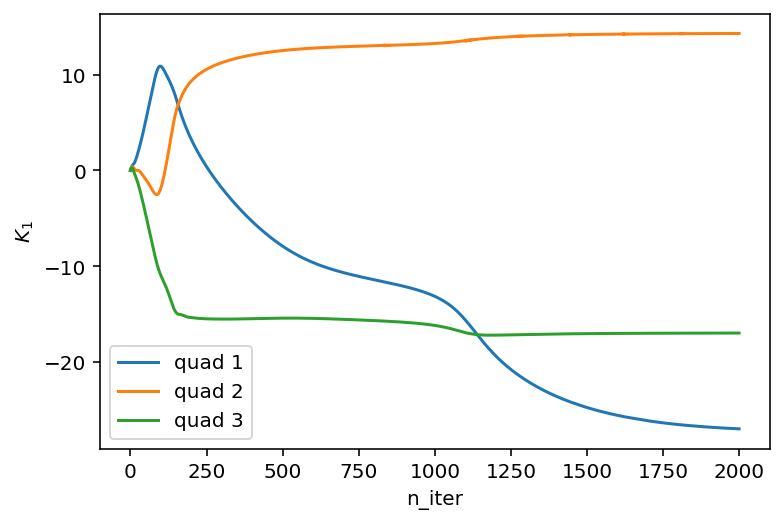

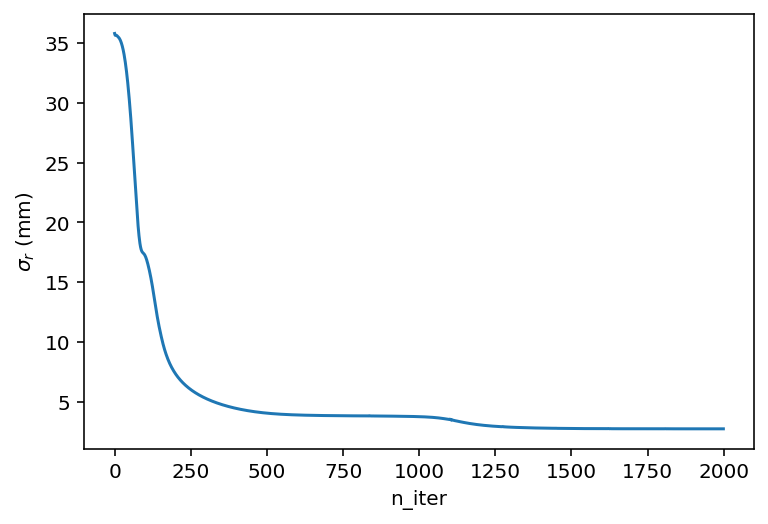

In [9]:
# Plot O.F. and parameters as function of iteration number
for i in range(len(k1s)):
    plt.plot(np.arange(len(params_k1s[:,0])), params_k1s[:,i], label='quad '+str(i+1))
plt.legend()
plt.ylabel(r'$K_1$')
plt.xlabel('n_iter')
plt.figure()
plt.plot(np.arange(len(obj_beamsize)), obj_beamsize*1000)
plt.ylabel(r'$\sigma_r$ (mm)')
plt.xlabel('n_iter')
#params, loss

In [10]:
# optimal k1s for minimal spot size at the end of the beamline:
k1s_opt = params_k1s[-1].copy()
k1s_opt

array([-26.941591496165387,  14.283967163958188, -16.953438026870685])

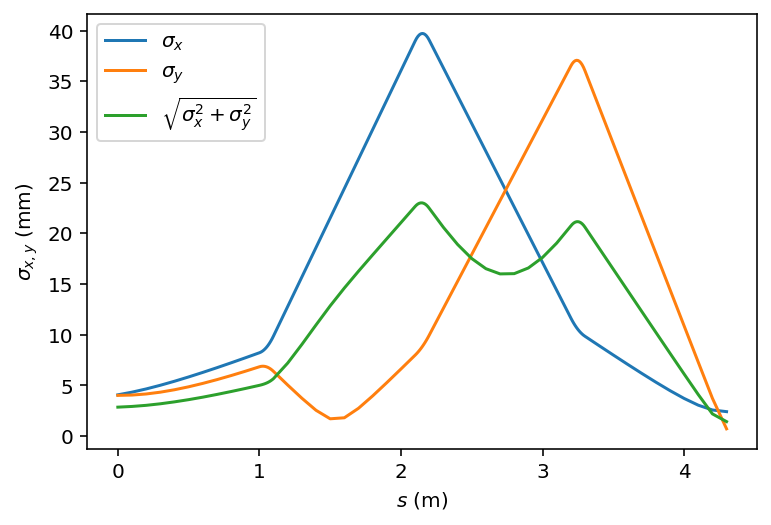

In [11]:
# plot beamsize for final config

# lattice: 
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L=L_d)
lattice = [drift]
for k1 in k1s_opt:
    lattice.append( torchquadrupole(L=L_q, K1=k1) )
    lattice.append( drift )
n=10 # number of slices per element for plotting
stubbed_lattice = stub_lattice(lattice, n)
all_p = track_a_lattice(p_in, stubbed_lattice)

# bunch properties to plot:
stdx = [torch.std(par.x) for par in all_p]
stdy = [torch.std(par.y) for par in all_p]
stdr = [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p]
s = [par.s for par in all_p]

# plot: 
plt.plot(s, np.array(stdx)*1000, label=r'$\sigma_x$')
plt.plot(s, np.array(stdy)*1000, label=r'$\sigma_y$')
plt.plot(s, np.array(stdr)*1000, label=r'$\sqrt{\sigma_x^2 + \sigma_y^2}$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

In [12]:
# k1s used to get offsets. Each quadrupole strength is increased once from the optimal configuration. 
epsilon = 0.1 # strength change precentage
k1s_tests = []
for i in range(3):
    k1s_tests.append(k1s_opt.copy())
    
k1s_tests[0][0]=k1s_opt[0]*(1+epsilon)
k1s_tests[1][1]=k1s_opt[1]*(1+epsilon/2)
k1s_tests[2][2]=k1s_opt[2]*(1+epsilon)

k1s_tests

[array([-29.63575064578193 ,  14.283967163958188, -16.953438026870685]),
 array([-26.941591496165387,  14.998165522156098, -16.953438026870685]),
 array([-26.941591496165387,  14.283967163958188, -18.648781829557755])]

In [13]:
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L=L_d)

# outgoing bunch with true offsets for each set of k1s
p_out_tests = []
for test in range(len(k1s_tests)):
    k1s = k1s_tests[test]
    lattice = [drift]
    for i in range(len(k1s)):
        lattice.append( torchquadrupole(L=L_q, K1=k1s[i], X_OFFSET=offsets_x_true[i]) )
        lattice.append( drift )
    p_out_tests.append( track_a_lattice(p_in, lattice)[-1] )

# outgoing particles with no offsets (for comparison purposes)
p_out_tests_no_offsets = []
for test in range(len(k1s_tests)):
    k1s = k1s_tests[test]
    lattice = [drift]
    for i in range(len(k1s)):
        lattice.append( torchquadrupole(L=L_q, K1=k1s[i]) )
        lattice.append( drift )
    p_out_tests_no_offsets.append( track_a_lattice(p_in, lattice)[-1] )

In [14]:
# differentiable transverse histogram version of p_out_tests

# screen (transverse histogram) parameters
n_bins = 200
lim = 50e-3
edges = torch.linspace(-lim, lim, n_bins, **tkwargs)
xx = torch.meshgrid((edges, edges), indexing='ij')

p_out_test_hist = []
for test in range(len(k1s_tests)):
    p_out_test_hist.append( histogram2d(
        p_out_tests[test].x.unsqueeze(0),
        p_out_tests[test].y.unsqueeze(0),
        edges, 
        bandwidth = torch.tensor(1e-3)  
    ) )
    p_out_test_hist[test] = p_out_test_hist[test] + histogram2d(
        p_out_tests[test].x.unsqueeze(0),
        p_out_tests[test].y.unsqueeze(0),
        edges, 
        bandwidth = torch.tensor(1e-1)  
    )

Text(0.5, 1.0, 'out (no offsets)')

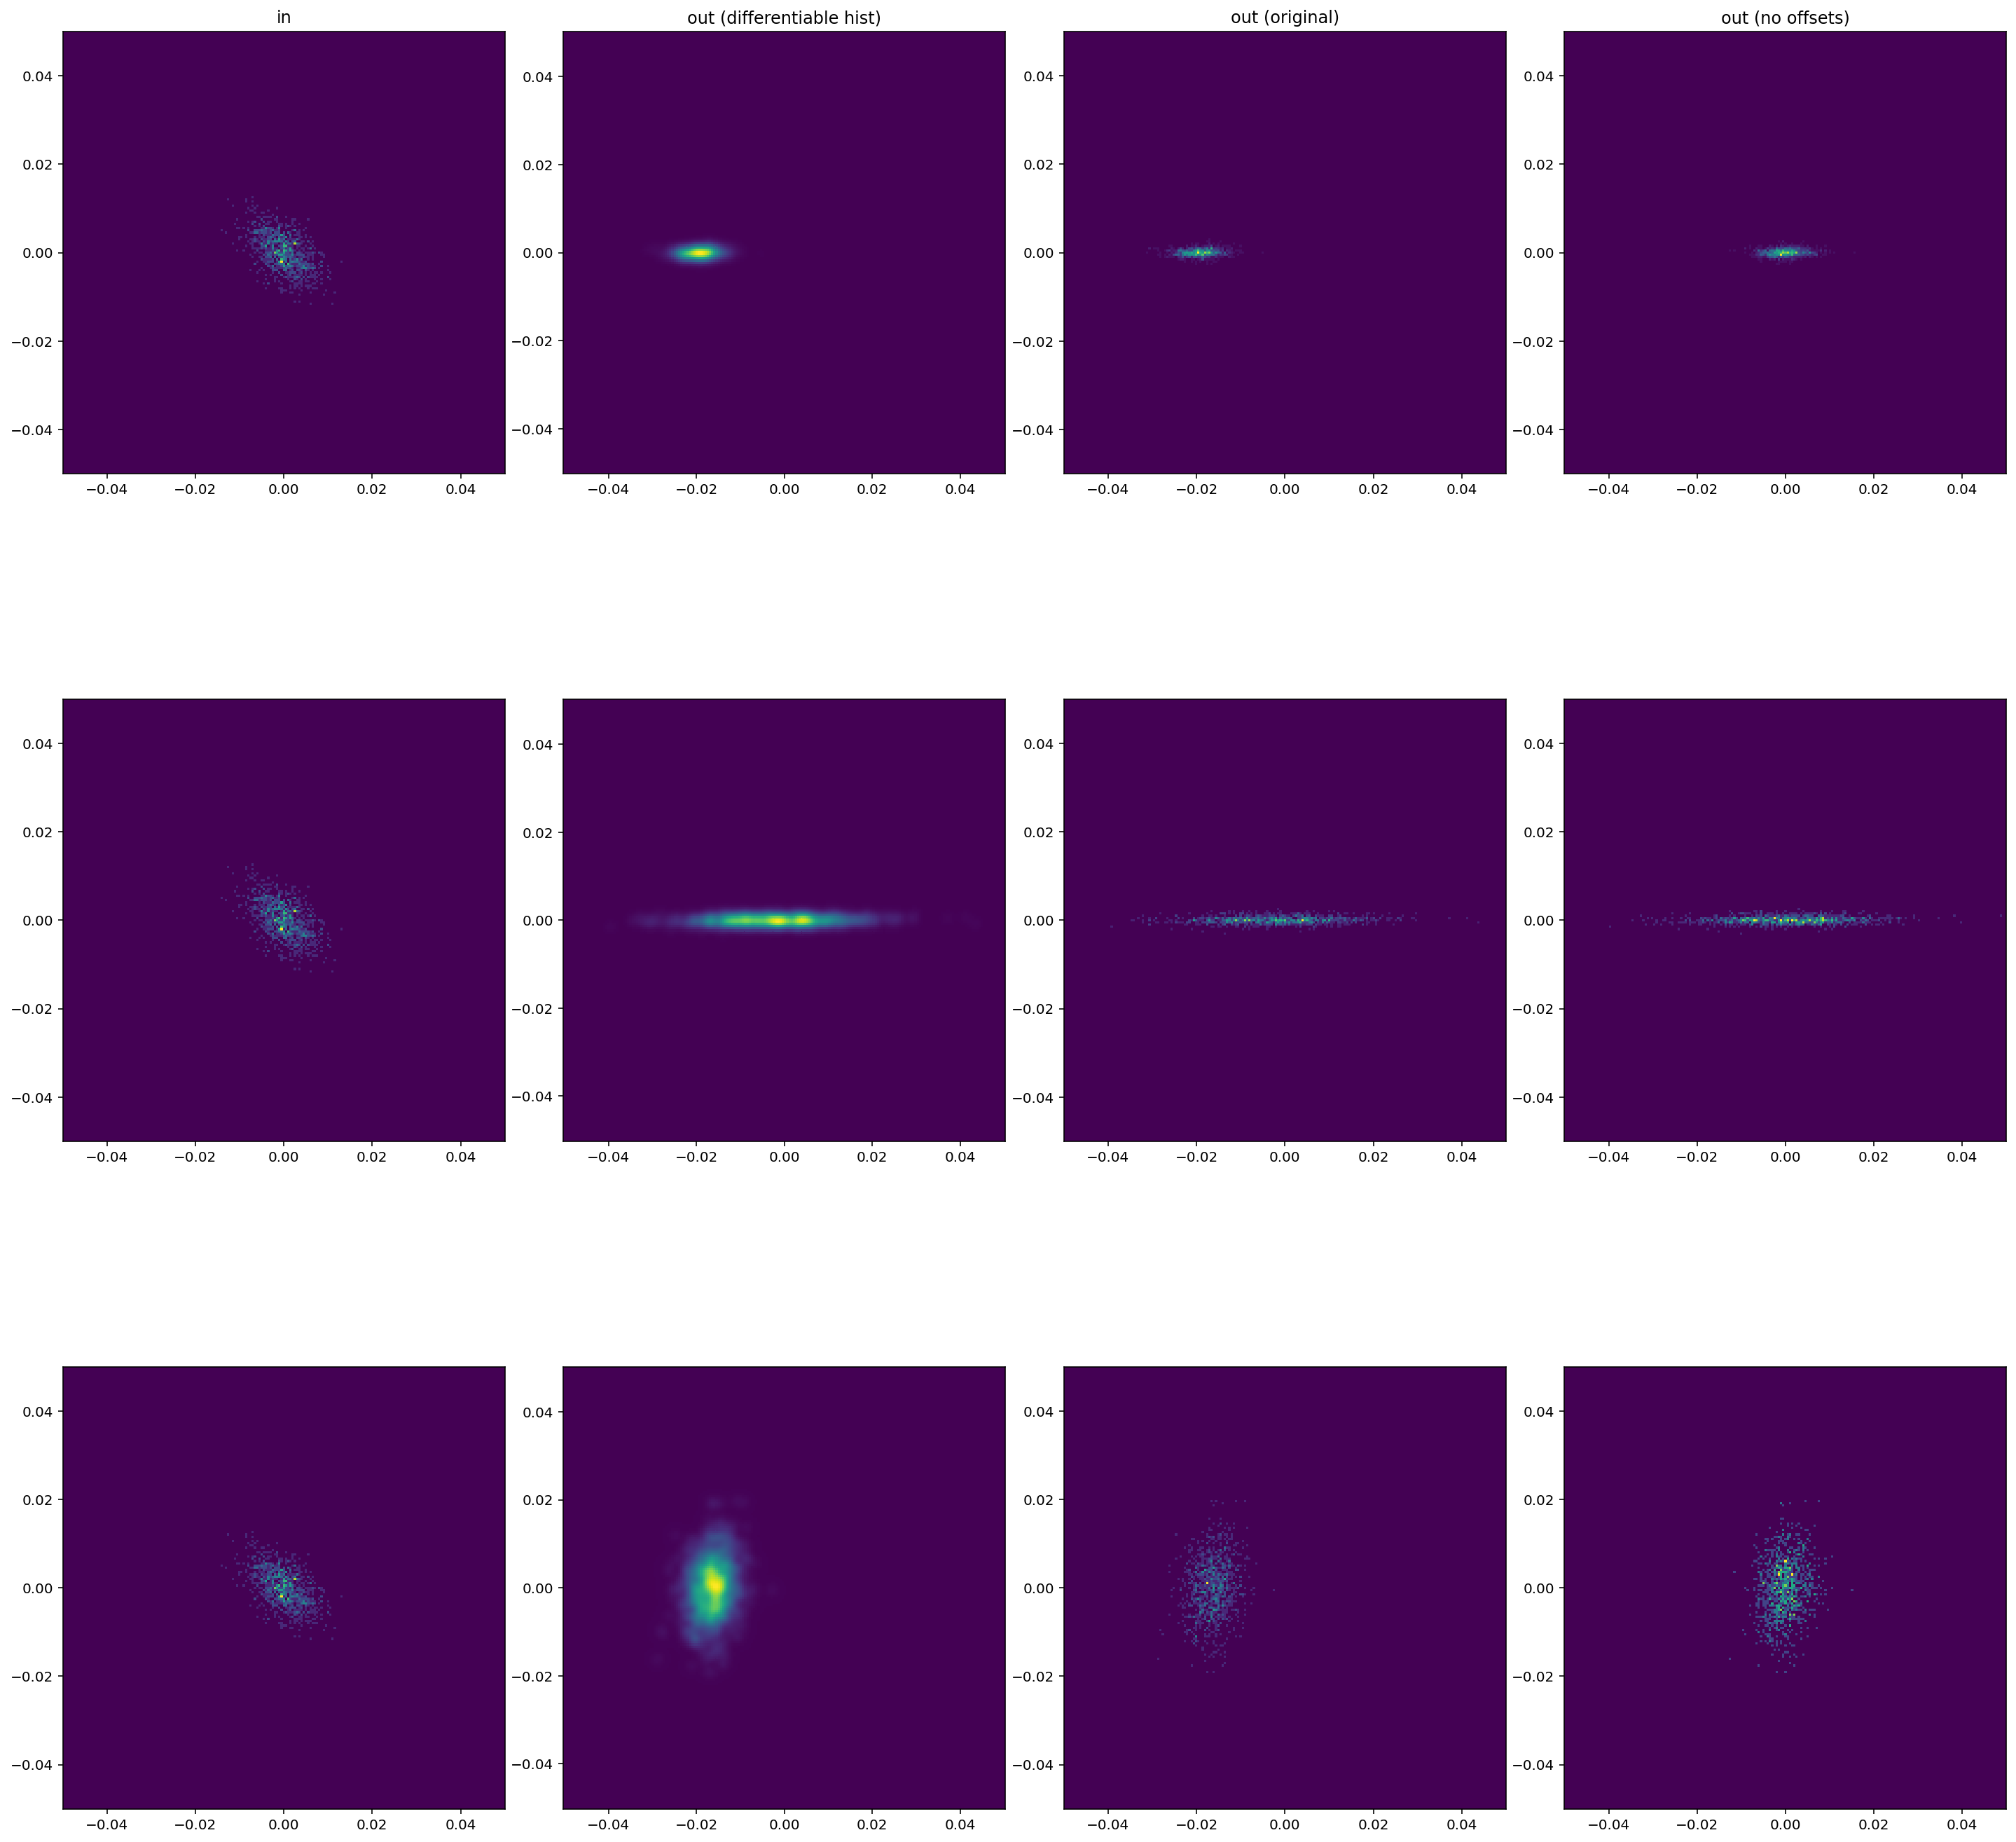

In [15]:
# plot in and out beams for each set of k1s

# incoming 2D beam profile
x_in = p_in.x.detach().numpy()
y_in = p_in.y.detach().numpy()

# outgoing 2D beam profiles
x_out = []
y_out = []
x_out_no_offsets = []
y_out_no_offsets = []
for test in range(len(k1s_tests)):
    x_out.append( p_out_tests[test].x.detach().numpy() )
    y_out.append( p_out_tests[test].y.detach().numpy() )
    x_out_no_offsets.append( p_out_tests_no_offsets[test].x.detach().numpy() )
    y_out_no_offsets.append( p_out_tests_no_offsets[test].y.detach().numpy() )

# figure
fig, ax = plt.subplots(len(k1s_tests),4, figsize=(20,20))
fig.tight_layout()
for test in range(len(k1s_tests)):
    ax[test,0].hist2d(x_in, y_in, bins=edges)
    ax[test,0].set_aspect('equal')
    #ax[test,0].set_title('in')
    ax[test,1].pcolor(*xx, p_out_test_hist[test].squeeze().detach())
    ax[test,1].set_aspect('equal')
    #ax[test,1].set_title('out (diff hist)')
    ax[test,2].hist2d(x_out[test],y_out[test], bins=edges)
    ax[test,2].set_aspect('equal')
    #ax[test,2].set_title('out (original)')
    ax[test,3].hist2d(x_out_no_offsets[test],y_out_no_offsets[test], bins=edges)
    ax[test,3].set_aspect('equal')
    #ax[test,3].set_title('out (no offsets)')
    
ax[0,0].set_title('in')
ax[0,1].set_title('out (differentiable hist)')
ax[0,2].set_title('out (original)')
ax[0,3].set_title('out (no offsets)')

In [16]:
#fig, ax = plt.subplots()
#ax.hist2d(x_out[4]*1000, y_out[4]*1000, bins=edges*1000)
#ax.set_aspect('equal')
#ax.set_xlabel("$x$ (mm)")
#ax.set_ylabel("$y$ (mm)")
#plt.savefig("out.eps")

In [17]:
#fig, ax = plt.subplots()
#ax.hist2d(x_out[4]*1000, y_out[4]*1000, bins=edges*1000)
#xxmm = torch.meshgrid((edges*1000, edges*1000), indexing='ij')
#ax.pcolor(*(xxmm), p_out_test_hist[4].squeeze().detach())
#ax.set_aspect('equal')
#ax.set_xlabel("$x$ (mm)")
#ax.set_ylabel("$y$ (mm)")
#plt.savefig("out_diff.eps")

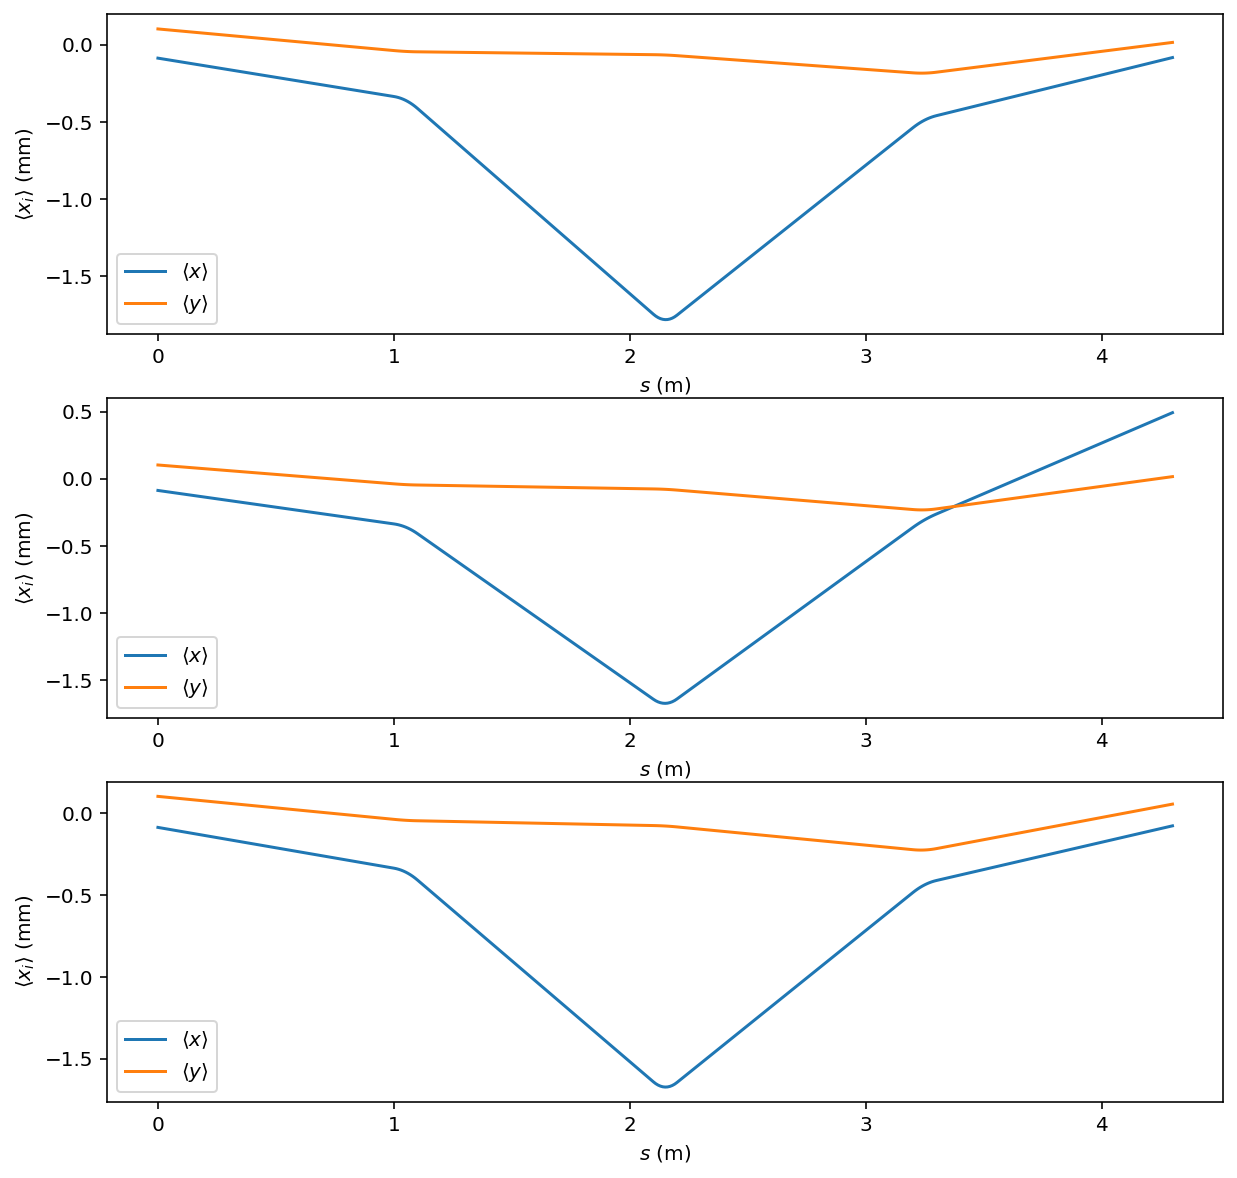

In [18]:
# centroid plots
fig, ax = plt.subplots(len(k1s_tests),1, figsize=(10,10))
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L=L_d)
for test in range(len(k1s_tests)):
    k1s = k1s_tests[test]
    lattice = [drift]
    for k1 in k1s:
        lattice.append( torchquadrupole(L=L_q, K1=k1) )
        lattice.append( drift )
    n=10
    stubbed_lattice = stub_lattice(lattice, n)
    all_p = track_a_lattice(p_in, stubbed_lattice)
    stdx, stdy, stdr, s = [torch.mean(par.x) for par in all_p], [torch.mean(par.y) for par in all_p], [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p], [par.s for par in all_p]
    ax[test].plot(s, np.array(stdx)*1000, label=r'$\langle x \rangle$')
    ax[test].plot(s, np.array(stdy)*1000, label=r'$\langle y \rangle$')
    #ax[test].plot(s, np.array(stdr)*1000, label=r'$\sqrt{\sigma_x^2 + \sigma_y^2}$')
    ax[test].set_xlabel(r'$s$ (m)')
    ax[test].set_ylabel(r'$\langle x_i \rangle$ (mm)')
    ax[test].legend()


## Finding offsets

In [19]:
def KL_divergence(y_true, y_pred):
    return torch.sum(y_true * (y_true.log() - y_pred.log()))

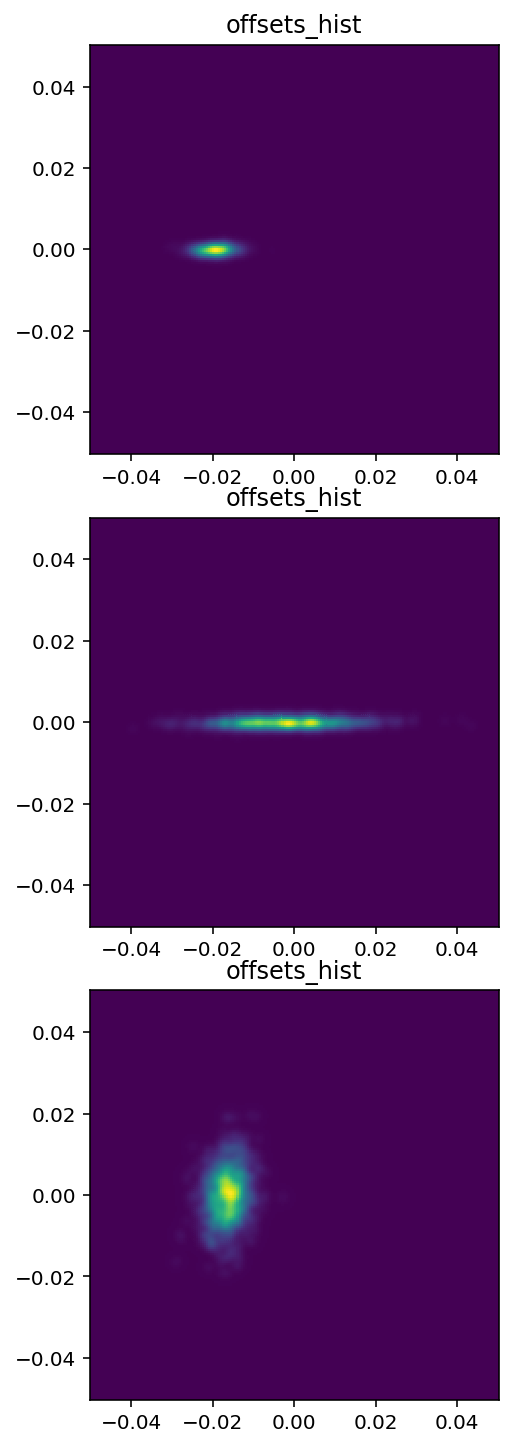

In [20]:
def get_beam_profile_hist(k1s, offsets_x, bandwidth=torch.tensor(1e-3)):
    """Returns the differentiable beam profile histogram."""
    # Lattice fixed parameters
    L_d = 1.00 # Drift length
    L_q = 0.1 # Quad length 
    drift = Drift(L=L_d)
    lattice = [drift]
    for i in range(len(k1s)):
        lattice.append( torchquadrupole(L=L_q, K1=k1s[i], X_OFFSET=offsets_x[i]) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    hist_pdf = histogram2d(
    p_out.x.unsqueeze(0),
    p_out.y.unsqueeze(0),
    edges,
    bandwidth=bandwidth
    )
    background = histogram2d(
    p_out.x.unsqueeze(0),
    p_out.y.unsqueeze(0),
    edges,
    bandwidth=torch.tensor(1e-1)
    )
    beam_profile_hist = hist_pdf + background
    return beam_profile_hist

ground_truth_hist = []
for i in range(len(k1s_tests)):
    ground_truth_hist.append( get_beam_profile_hist(k1s_tests[i], offsets_x_true) )

# plot beam profile differentiable histograms
fig, ax = plt.subplots(len(k1s_tests),1, figsize=(10,10))
fig.tight_layout()
for test in range(len(k1s_tests)):
    ax[test].pcolor(*xx, ground_truth_hist[test].squeeze().detach())
    ax[test].set_aspect('equal')
    ax[test].set_title('offsets_hist')

In [21]:
class OffsetModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s_tests, offsets_x):
        super().__init__()
        self.k1s_tests = k1s_tests
        self.register_parameter('offsets_x',torch.nn.Parameter(offsets_x))
    def forward(self):
        KL_sum=0
        for i in range(len(k1s_tests)):
            KL_sum+=KL_divergence(ground_truth_hist[i], get_beam_profile_hist(self.k1s_tests[i], self.offsets_x))
        return KL_sum

In [22]:
%%time
# Initial offsets
offsets_x = torch.zeros(3,**tkwargs)
#offsets_x = offsets_x_pred
# Optimization
model = OffsetModel(k1s_tests, offsets_x)
params, loss = train_model(model, 5000, 1e-4)

offsets_x : Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)
Iter 1/5000 - Loss: 8.12352 
Iter 101/5000 - Loss: 0.80440 
Iter 201/5000 - Loss: 0.63794 
Iter 301/5000 - Loss: 0.47013 
Iter 401/5000 - Loss: 0.33882 
Iter 501/5000 - Loss: 0.24253 
Iter 601/5000 - Loss: 0.17829 
Iter 701/5000 - Loss: 0.12478 
Iter 801/5000 - Loss: 0.08650 
Iter 901/5000 - Loss: 0.07483 
Iter 1001/5000 - Loss: 0.06944 
Iter 1101/5000 - Loss: 0.06465 
Iter 1201/5000 - Loss: 0.05989 
Iter 1301/5000 - Loss: 0.05516 
Iter 1401/5000 - Loss: 0.05049 
Iter 1501/5000 - Loss: 0.04593 
Iter 1601/5000 - Loss: 0.04151 
Iter 1701/5000 - Loss: 0.03726 
Iter 1801/5000 - Loss: 0.03320 
Iter 1901/5000 - Loss: 0.02937 
Iter 2001/5000 - Loss: 0.02578 
Iter 2101/5000 - Loss: 0.02245 
Iter 2201/5000 - Loss: 0.01938 
Iter 2301/5000 - Loss: 0.01659 
Iter 2401/5000 - Loss: 0.01407 
Iter 2501/5000 - Loss: 0.01182 
Iter 2601/5000 - Loss: 0.00982 
Iter 2701/5000 - Loss: 0.00808 
Iter 2801/5000 - Los

Text(0.5, 0, 'n_iter')

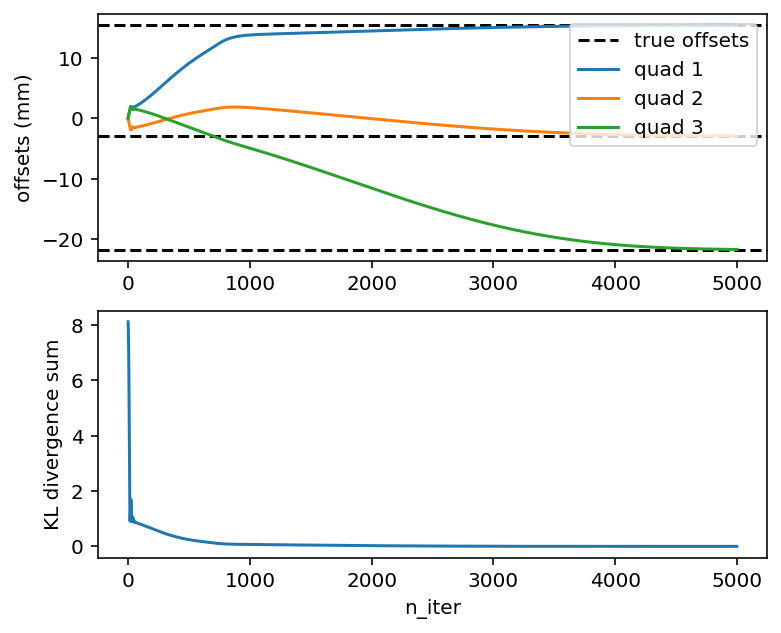

In [23]:
fig, ax = plt.subplots(2,1, figsize=(6,5))
for i in range(len(k1s_opt)):
    if i == 0:
        ax[0].axhline(offsets_x_true[i]*1000, color='black', linestyle="--", label='true offsets')
    else:
        ax[0].axhline(offsets_x_true[i]*1000, color='black', linestyle="--")
    ax[0].plot(np.arange(len(params[:,0])), params[:,i]*1000, label='quad '+str(i+1))
ax[0].legend(loc=1)
ax[0].set_ylabel(r'offsets (mm)')
#ax[0].set_xlabel('n_iter')
ax[1].plot(np.arange(len(loss)), (loss))
ax[1].set_ylabel(r'KL divergence sum')
ax[1].set_xlabel('n_iter')
#params, loss
#plt.savefig("offset_iter.eps")

In [24]:
def plot_beam_profiles(y_true, y_pred, edg):
    xx = torch.meshgrid((edg, edg), indexing='ij')
    num_tests = len(y_true)
    fig, ax = plt.subplots(num_tests,2, figsize=(20,20))
    fig.tight_layout()
    for i in range(num_tests):
        ax[i,0].pcolor(*xx, y_true[i].squeeze().detach())
        ax[i,0].set_aspect('equal')
        ax[i,0].set_title('ground truth')
        ax[i,1].pcolor(*xx, y_pred[i].squeeze().detach())
        ax[i,1].set_aspect('equal')
        ax[i,1].set_title('prediction')

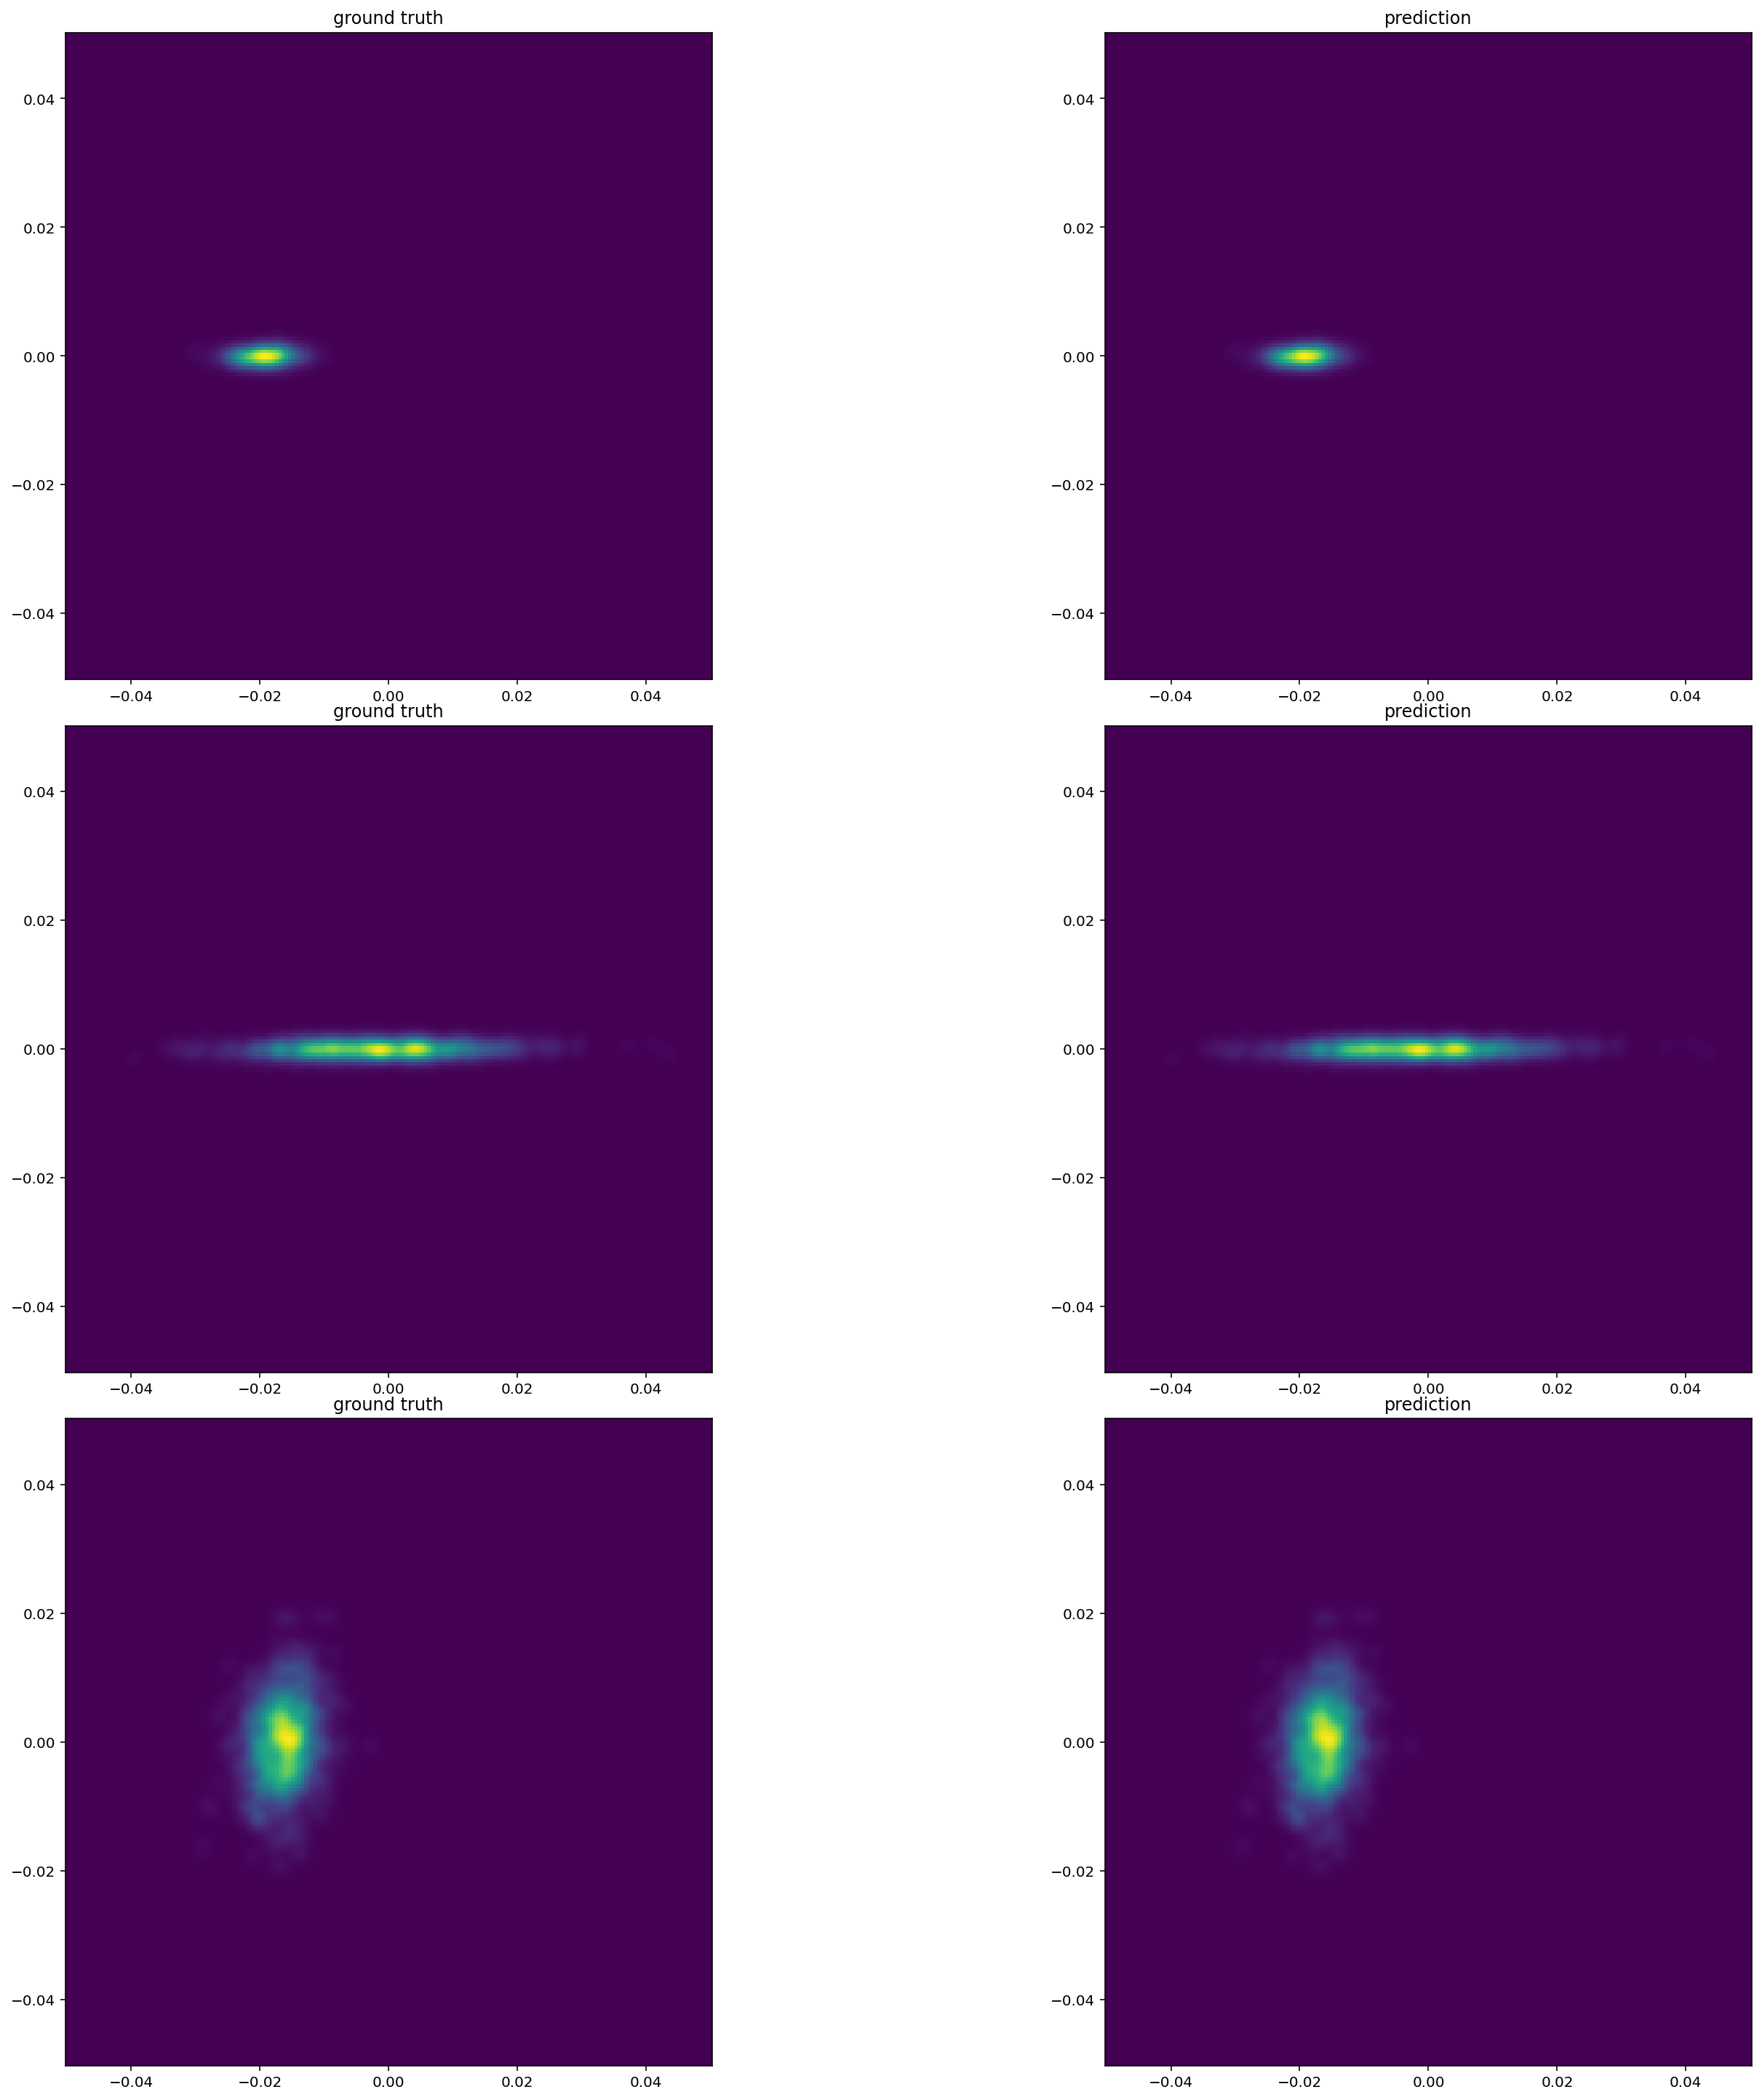

In [25]:
offsets_x_pred = torch.tensor(params[-1].copy(), **tkwargs)
#a = [get_beam_profile_hist(k1s_tests , offsets_x_pred) for k1s in k1s_tests]
a = [get_beam_profile_hist(k1s , offsets_x_pred) for k1s in k1s_tests]
plot_beam_profiles(ground_truth_hist, a,edges)

In [26]:
(offsets_x_true, offsets_x_pred)

(tensor([1.5409961082440433e-02, -2.9342890576094637e-03, -2.1787893820745575e-02],
        dtype=torch.float64),
 tensor([1.5404106678908000e-02, -2.9165154045160163e-03, -2.1724610316332493e-02],
        dtype=torch.float64))